In [363]:
%matplotlib notebook
# We start off with the baseline import statements we need to do the basic data manipulation and visualization.
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import calendar
from sklearn.ensemble import RandomForestClassifier

sns.set_style("whitegrid")

#We create and set aside a copy of the data for initial exploration
housing_train = pd.read_csv('../data/train.csv')
housing = housing_train.copy()

#MISSING DATA
total = housing.isnull().sum().sort_values(ascending=False)
percent = (housing.isnull().sum()/housing.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#CORRELATION CHECK
corr_matrix = housing.corr()
top_corr = corr_matrix['SalePrice'].sort_values(ascending = False)

In [364]:
#DROPPING SOME COLUMNS
drop = ['PoolQC', 'PoolArea','MiscFeature', 'MiscVal', 'Alley', 'Fence', 'FireplaceQu', 'Fireplaces', 'LotFrontage']
drop2 = ['Id','GarageArea','1stFlrSF','GarageYrBlt']
housing.drop(columns = drop + drop2, inplace = True)
housing['Age'] = housing['YrSold'] - housing['YearBuilt']
housing['AgeRemodel'] = housing['YrSold'] - housing['YearRemodAdd']
housing = housing[housing.AgeRemodel >= 0]
housing.drop(columns = ['YearBuilt','YearRemodAdd'], inplace = True)

In [388]:
#FURTHER DATA CLEANING
housing_cat = housing.select_dtypes(exclude=[np.number])
housing_numeric = housing.select_dtypes(include=[np.number])

#Numeric
numeric_unbounded = ['LotArea', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea','WoodDeckSF',
                     'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'SalePrice',
                     'Age','AgeRemodel']

numeric_one_hot = ['MSSubClass','MoSold']

numeric_ordinal = [x for x in housing_numeric.columns 
                   if (x not in numeric_unbounded and x not in numeric_one_hot)]

housing_numeric_unbounded = housing_numeric[numeric_unbounded]
housing_numeric_one_hot = housing_numeric[numeric_one_hot]
housing_numeric_ordinal = housing_numeric[numeric_ordinal]

housing_numeric_one_hot['MSSubClass'] = housing_numeric_one_hot['MSSubClass'].astype('str')
housing_numeric_one_hot['MoSold'] = housing_numeric_one_hot['MoSold'].replace({i:calendar.month_name[i][:3] for i in range(1,13)})
housing_numeric_one_hot = pd.get_dummies(housing_numeric_one_hot)

#Categorical
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'HeatingQC', 'KitchenQual','Functional','GarageFinish',
               'GarageQual', 'GarageCond']

housing_cat_ordinal = housing_cat[cat_ordinal]
housing_cat_ordinal.fillna('None', inplace = True)
housing_cat_one_hot = housing_cat.drop(columns = cat_ordinal)
housing_cat_one_hot = pd.get_dummies(housing_cat_one_hot)

def mapper(cat):
    if cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
               'HeatingQC', 'KitchenQual']:
        mapper = {'None':0, 'Po':1, 'Fa':2,'TA':3,'Gd':4,'Ex':5}
    elif cat == 'BsmtExposure':
            mapper = {'None':0,'No':1, 'Mn':2, 'Av':3,'Gd':4}
    elif cat == 'BsmtFinType1':
        mapper = {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
    elif cat == 'Functional':
        mapper = {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5, 'Min1':6,'Typ':7}
    else:
        mapper = {'None':0,'Unf':1,'RFn':2,'Fin':3}
        
    return mapper

for cat in cat_ordinal:
    housing_cat_ordinal[cat].replace(mapper(cat), inplace = True)

#Combining numeric and categorical
housing_ordinal = pd.concat([housing_numeric_ordinal,housing_cat_ordinal], axis = 'columns')
housing_one_hot = pd.concat([housing_numeric_one_hot, housing_cat_one_hot], axis = 'columns')
housing_clean = pd.concat([housing_one_hot, housing_ordinal, housing_numeric_unbounded], 
                          axis = 'columns')

#MORE CORRELATION
ordinal_prices = pd.concat([housing_ordinal, housing['SalePrice']], axis = 'columns')
ordinal_corr_matrix = ordinal_prices.corr()
top_corr_ordinal = ordinal_corr_matrix['SalePrice'].sort_values(ascending = False)

one_hot_prices = pd.concat([housing_one_hot, housing['SalePrice']], axis = 'columns')
one_hot_corr_matrix = one_hot_prices.corr()
top_corr_one_hot = one_hot_corr_matrix['SalePrice'].filter(like = 'Neighborhood').sort_values(ascending = False)

In [389]:
#REMOVAL OF THE REMAINING NaN
housing_clean.isnull().sum().sort_values(ascending=False)
df = housing_clean.copy()
problem_col = df.isin([np.nan, np.inf, -np.inf]).sum(axis=0)[df.isin([np.nan, np.inf, -np.inf]).sum(axis=0) != 0] 
index_to_drop = df[problem_col.index[0]][df[problem_col.index[0]].isin([np.nan, np.inf, -np.inf])].index
df.drop(index = index_to_drop, inplace = True)
# df.isnull().sum().sort_values(ascending=False)

In [390]:
#RANDOM FOREST FOR FEATURE IMPORTANCE
X_train = df.drop(columns = ['SalePrice'])
y_train = df['SalePrice']

forest = RandomForestClassifier(n_estimators=500, max_depth=4)

forest.fit(X_train, y_train)

forest.feature_importances_
score_df = pd.DataFrame({'feature':X_train.columns,
                            'importance_score': forest.feature_importances_})

In [391]:
#We will look at feature importances and their correlation with the 'SalePrice'
score_df.sort_values('feature', inplace=True)
top_corr = df.corr()['SalePrice'].abs().drop(index = ['SalePrice']) #I suppose we want to look at the absolute value
                                                                    #of the correlation. Is that right?
top_corr.sort_index(inplace=True) 
#now rows of score_df and top_corr match and we can add the values of correlation
score_df['correlation'] = top_corr.values

In [392]:
score_df.sort_values(ascending=False, by = ['importance_score'], inplace = True)
score_df['importance_score_rank'] = [k for k in range(1,1+len(score_df.index))]
score_df.sort_values(ascending=False, by = ['correlation'], inplace = True)
score_df['correlation_rank'] = [k for k in range(1,1+len(score_df.index))]
score_df['overall_rank'] = (score_df['importance_score_rank'] + score_df['correlation_rank'])/2 
score_df.sort_values(ascending=True, by = ['overall_rank'], inplace = True)
score_df.reset_index(drop = True, inplace = True)
score_df.head(20)

,feature,importance_score,correlation,importance_score_rank,correlation_rank,overall_rank
0,OverallQual,0.028362,0.792084,2,1,1.5
1,GrLivArea,0.028254,0.718891,3,2,2.5
2,TotalBsmtSF,0.022505,0.617630,6,6,6.0
3,Age,0.026523,0.523432,4,11,7.5
4,KitchenQual,0.015890,0.659501,13,4,8.5
5,FullBath,0.017806,0.563726,10,8,9.0
6,GarageCars,0.014844,0.640228,15,5,10.0
7,TotRmsAbvGrd,0.017750,0.537623,11,10,10.5
8,AgeRemodel,0.018273,0.509143,9,12,10.5
9,ExterQual,0.012794,0.682920,20,3,11.5


Correlation measures only linear dependence between variables and it does not detect non-linear dependence (in particular cor(X,Y) can be 0 for random variables X and Y=X^2, which are of course completely dependent). So, if a given feature has high feature_importance score, but low correlation it means that 'SalePrice' depend on it in a non-linear manner.

<IPython.core.display.Javascript object>


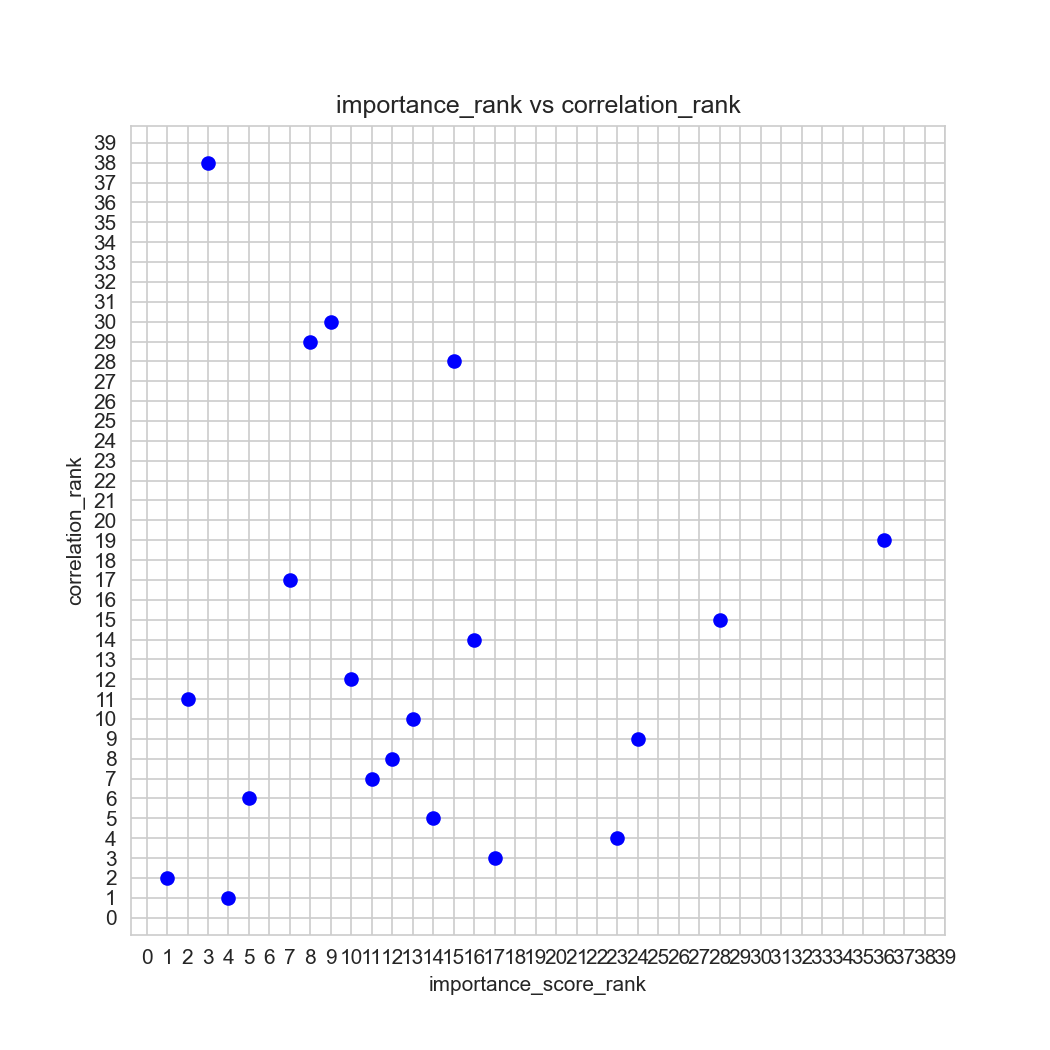

In [387]:
plt.figure(figsize=(7, 7))
plt.scatter(score_df['importance_score_rank'][:20], score_df['correlation_rank'][:20], c ="blue",
            linewidths = 1)
plt.title('importance_rank vs correlation_rank')
plt.xticks(np.arange(0, 40, step=1))
plt.yticks(np.arange(0, 40, step=1))
plt.xlabel("importance_score_rank")
plt.ylabel("correlation_rank")
plt.show()